<a href="https://colab.research.google.com/github/LeLoMAu/LeLoMAu/blob/main/pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Scikit-Learn**

In [524]:
# Load required packages
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import Memory
from shutil import rmtree
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import time
import copy

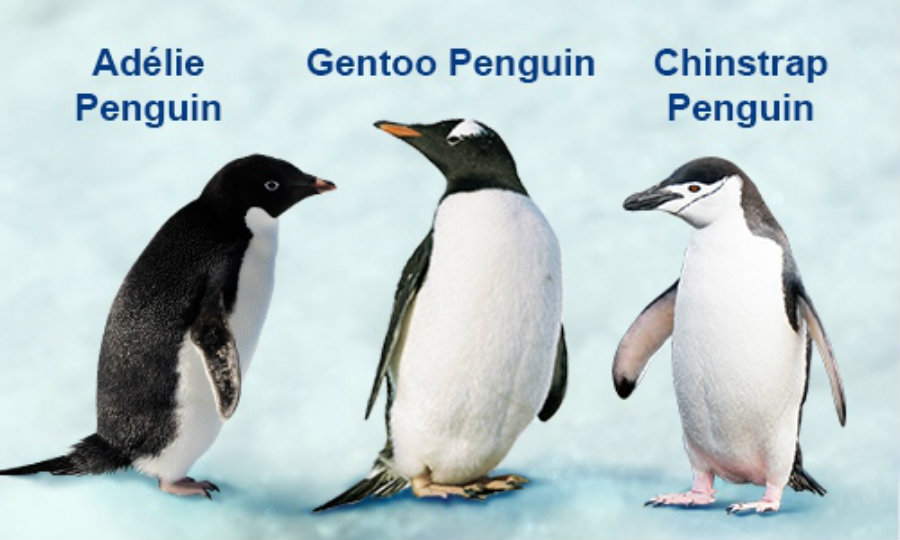

In [525]:
# Load data
df = sns.load_dataset('penguins')

# From multiclass (Adelie, Chinstrap, Gentoo) to binary (Adelie, Other), for simplicity
df['species'] = df['species'].apply(lambda x: x if x == 'Adelie' else 'Other')

# Encode categorical variables
df.loc[:, 'species'] = LabelEncoder().fit_transform(df['species'])

# Divide feature columns by type
numerical_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
categorical_cols = ["island", "sex"]

df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,0,Torgersen,39.5,17.4,186.0,3800.0,Female
2,0,Torgersen,40.3,18.0,195.0,3250.0,Female
3,0,Torgersen,NaN,NaN,NaN,NaN,NaN
4,0,Torgersen,36.7,19.3,193.0,3450.0,Female


In [526]:
# Separate x and y columns
df_x = df.drop('species', axis=1)
df_y = df[['species']]

# Train/Test split
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=0.05, random_state=0, stratify=df_y)

## Define a single **pipeline**

**Pipeline**: sequentially apply a list of **transforms** and a final **estimator**.
*   Intermediate steps of the pipeline must be **transforms**, that is, they must implement *fit* and *transform* methods.  
*   The final **estimator** only needs to implement *fit*.  
*   The transformers in the pipeline can be *cached* using memory argument.

In [527]:
# Define the steps of the pipeline
steps = [
    ("imputation", SimpleImputer()),
    ("classifier", RandomForestClassifier()),
]

# Create the pipeline object
pipe = Pipeline(steps)

In [528]:
# Different way to view the pipeline: text, diagram, 
set_config(display="diagram")
pipe

Pipeline(steps=[('imputation', SimpleImputer()),
                ('classifier', RandomForestClassifier())])

## **Branch** and **Chain** multiple pipelines

In [529]:
# Define steps of each pipeline
numeric_prep_steps=[
    ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("scaler", StandardScaler())
]
categorical_prep_steps=[
    ("imputation_constant", SimpleImputer(fill_value="missing", strategy="constant")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
]

# Define pipeline objects
numeric_prep_pipeline = Pipeline(steps=numeric_prep_steps)
categorical_prep_pipeline = Pipeline(steps=categorical_prep_steps)

# Branch a pipeline, using ColumnTransformer
# ColumnTransformer: applies transformers to columns of an array or pandas DataFrame. 
# It is useful to combine several feature transformations into a single transformer.
prep = ColumnTransformer([
    ("numerical", numeric_prep_pipeline, numerical_cols),
    ("categorical", categorical_prep_pipeline, categorical_cols),
])

# Chain multiple pipeline
pipe = Pipeline(steps=[("preprocessor", prep), ("classifier", RandomForestClassifier(n_estimators=200, max_features='log2'))])

# Display the pipeline
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['island', 'sex'])])),
                ('classifier',
                 RandomForestClassifier(max_features='log2',
                                        n_estimators=200))])

## What's the **purpose** of a pipeline?

### Hyperparameter-tuning

In [530]:
# Let's define a wait transformer, just for caching demo
class WaitTransformer(BaseEstimator, TransformerMixin):
  def __init__(self) -> None:
      super().__init__()

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    time.sleep(0.3)
    return X

In [531]:
# Add wait transformer - without caching
pipe = Pipeline(steps=[
    ("preprocessor", prep), 
    ("waiter", WaitTransformer()), 
    ("classifier", RandomForestClassifier(n_estimators=200, max_features='log2'))]
)

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['island', 'sex'])])),
                ('waiter', WaitTransformer()),
                ('classifier',
                 RandomForestClassifier(max_features='log2',
                                        n_estimators=200))])

In [532]:
# Define Cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

# Define hyperparameter search space
param_grid = {
    "classifier__max_depth": [5, 6],
    "classifier__criterion": ["gini", "entropy"],
}

In [533]:
# Define search strategy - grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=1, cv=cv, scoring='roc_auc')

# Start hyperparameter tuning (around 58 secs)
start_time = time.time()
grid_search.fit(train_x, train_y.astype('int').values.ravel())

print("--- %s seconds, without caching ---" % (time.time() - start_time))

--- 56.34263634681702 seconds, without caching ---


In [534]:
# Redefine pipeline, adding caching
# Intermediate results are saved in a temporary folder called "cachedir"
memory = Memory(location="cachedir", verbose=0)
pipe = Pipeline(pipe.steps, memory=memory)

# Define search strategy - grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=1, cv=cv, scoring='roc_auc')

# Start hyperparameter tuning (around 40 secs)
start_time = time.time()
grid_search.fit(train_x, train_y.astype('int').values.ravel())

print("--- %s seconds, with caching---" % (time.time() - start_time))

# Delete the temporary cache before exiting
memory.clear(warn=False)
rmtree("cachedir")

--- 43.25172781944275 seconds, with caching---


In [535]:
# Make predictions (using the best model found)
grid_search.predict(test_x)

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1])

In [536]:
# Display optimal hyperparameter
grid_search.best_params_

{'classifier__criterion': 'entropy', 'classifier__max_depth': 6}

### Package model and pre-processing

Imagine that pipelines don't exist: what would you do?

In [537]:
# Training phase

# Make a copy of data, to not override
c_train_x = copy.deepcopy(train_x)
c_test_x = copy.deepcopy(test_x)

# Numeric Imputation
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
c_train_x[numerical_cols] = numeric_imputer.fit_transform(c_train_x[numerical_cols])

# Numeric Scaling
numeric_scaler = StandardScaler()
c_train_x[numerical_cols] = numeric_scaler.fit_transform(c_train_x[numerical_cols])

# Categorical Imputation
categorical_imputer = SimpleImputer(fill_value="missing", strategy="constant")
c_train_x[categorical_cols] = categorical_imputer.fit_transform(c_train_x[categorical_cols])

# Categorical Encoding
c_train_x = pd.get_dummies(c_train_x)

# Train model, using best hyperparameters found before
model = RandomForestClassifier(
    n_estimators=200, 
    criterion='gini', 
    max_depth=6, 
    max_features='log2'
)
model.fit(c_train_x, train_y.astype('int').values.ravel())

# Save preprocessing components and model for later use
pickle.dump(numeric_imputer, open('my_numeric_imputer', 'wb'))
pickle.dump(numeric_scaler, open('my_numeric_scaler', 'wb'))
pickle.dump(categorical_imputer, open('my_categorical_imputer', 'wb'))
pickle.dump(model, open('my_model', 'wb'))

In [538]:
# Three months later... Predict phase

# Retrieve preprocessing components and model
numeric_imputer = pickle.load(open('my_numeric_imputer', 'rb'))
numeric_scaler = pickle.load(open('my_numeric_scaler', 'rb'))
categorical_imputer = pickle.load(open('my_categorical_imputer', 'rb'))
model = pickle.load(open('my_model', 'rb'))

# Apply preprocessing to production data
c_test_x[numerical_cols] = numeric_imputer.transform(c_test_x[numerical_cols])
c_test_x[numerical_cols] = numeric_scaler.transform(c_test_x[numerical_cols])
c_test_x[categorical_cols] = categorical_imputer.transform(c_test_x[categorical_cols])
c_test_x = pd.get_dummies(c_test_x)

# Predict
model.predict(c_test_x)

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1])

Using pipelines

In [539]:
# Training phase

# Redefine pipeline, using best hyperparameters found before
pipe = Pipeline(steps=[
    ("preprocessor", prep), 
    ("classifier", RandomForestClassifier(
        n_estimators=200, 
        criterion='gini', 
        max_depth=6, 
        max_features='log2')
    )]
)

# Fit the model
pipe.fit(train_x, train_y.astype('int').values.ravel())

# Save the model for later use
pickle.dump(pipe, open('my_model', 'wb'))

In [540]:
# Three months later... Predict phase

# Retrieve the model
model = pickle.load(open('my_model', 'rb'))

# Apply preprocessing to production data and predict
model.predict(test_x)

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1])